# Convolutional Neural Network Modeling and Evaluation
*Run on Google Colaboratory VM*

# Imports, Updates, etc.

In [1]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 60.6 MB/s 
     |████████████████████████████████| 1.7 MB 42.5 MB/s 
     |████████████████████████████████| 5.9 MB 36.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd

from glob import glob
from PIL import Image

import librosa as lr
from librosa.display import waveplot, specshow
from librosa.core.spectrum import amplitude_to_db
from librosa.feature import melspectrogram

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.10.0
[]



In [4]:
#!pip install tensorflow_addons
#import tensorflow_addons as tfa
#f1_scorer = tfa.metrics.F1Score(10, average='macro', name='f1_macro', threshold=0.5)

# Classical Metrics for Comparison:

In [5]:
classical_ML_mets = pd.read_csv('/content/drive/MyDrive/Springboard/Classical_ML_Metrics.csv', index_col='Unnamed: 0')
classical_ML_mets

,accuracy,cv best f1,test macro avg f1,Train AUC,Test AUC
KNearestNeighbors,0.615,0.603849,0.608323,0.965472,0.912458
LogisticRegression,0.700,0.685577,0.691909,0.979939,0.949750
SVM,0.705,0.710727,0.698152,0.999988,0.956889
XGBoost,0.725,0.686891,0.719013,1.000000,0.951889
GradientBoostingClassifier,0.700,0.687605,0.690294,1.000000,0.951528


# Load and Check Melspectrograms
(and generate replacement melspec for Jazz song 54)

In [6]:
melspec_folder = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

In [7]:
!ls '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [8]:
blues_pngs = glob(melspec_folder + '/blues/*.png')
classical_pngs = glob(melspec_folder + '/classical/*.png')
country_pngs = glob(melspec_folder + '/country/*.png')
disco_pngs = glob(melspec_folder + '/disco/*.png')
hiphop_pngs = glob(melspec_folder + '/hiphop/*.png')
jazz_pngs = glob(melspec_folder + '/jazz/*.png')
metal_pngs = glob(melspec_folder + '/metal/*.png')
pop_pngs = glob(melspec_folder + '/pop/*.png')
reggae_pngs = glob(melspec_folder + '/reggae/*.png')
rock_pngs = glob(melspec_folder + '/rock/*.png')

In [9]:
blues_pngs[:3]

['/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00031.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00033.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00028.png']

In [10]:
print(len(jazz_pngs))

100


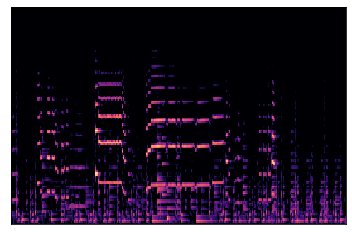

In [11]:
y, sr = lr.load('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav') # Replacement melspec for corrupted Jazz song (no. 54)
time = np.arange(0, len(y)) / sr
y_melspec = melspectrogram(y, sr=sr)
melspec_db = amplitude_to_db(np.abs(y_melspec))
jazz_melspec = specshow(melspec_db, sr=sr, cmap='magma');
# plt.savefig('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

Making sure the replacement melspectrogram resembles the others...

In [12]:
im = Image.open('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')
print(im.format, im.size, im.mode)

PNG (432, 288) RGBA


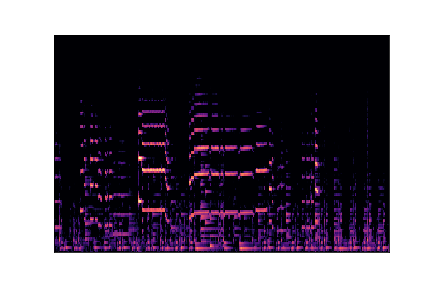

In [13]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

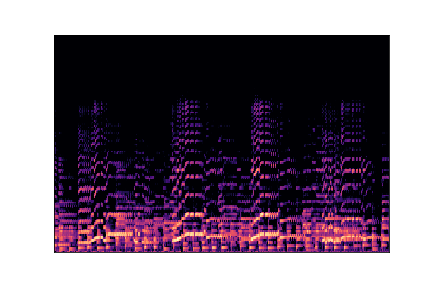

In [14]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00055.png')

# Split into training, validation, and test data tensors

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://github.com/keras-team/keras/issues/15985#issuecomment-1165831985

train_ds, test_ds = image_dataset_from_directory(melspec_folder,
                                             labels='inferred',
                                             label_mode = 'int',
                                             color_mode = 'rgb',
                                             image_size = (432, 288),
                                             validation_split = 0.1,
                                             subset = 'both',
                                             seed = 42)

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Using 200 files for validation.


In [16]:
tr_ds, val_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, right_size=0.2, shuffle=True, seed=42)

print(tr_ds, '\n', val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [17]:
# Optimize for speed, utils.split_dataset() converts to PrefetchDataset, so only needed for unsplit test_ds
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
print(len(tr_ds), len(val_ds), val_ds)
print(len(train_ds), len(test_ds), test_ds)

23 3 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
25 7 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 432, 288, 3)
(32,)


In [21]:
def unpack_batchdataset(dataset):
  train_imgs = []
  train_labels = []
  for i, j in dataset:
    train_imgs.append(i)
    train_labels.append(j)
  return train_imgs, train_labels

In [22]:
'''
train_imgs, train_labels = unpack_batchdataset(train_dataset)
test_imgs, test_labels = unpack_batchdataset(val_dataset)
''';

In [23]:
#print(type(train_imgs), type(train_imgs[0]), type(train_imgs[0][0]), type(train_imgs[0][0][0]), type(train_imgs[0][0][0][0]), train_labels[0].dtype, train_labels[0])

In [24]:
# Keeping a dict that links genre_label_str to genre_label_int
genre_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
              'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

Quick view of the melspecs:

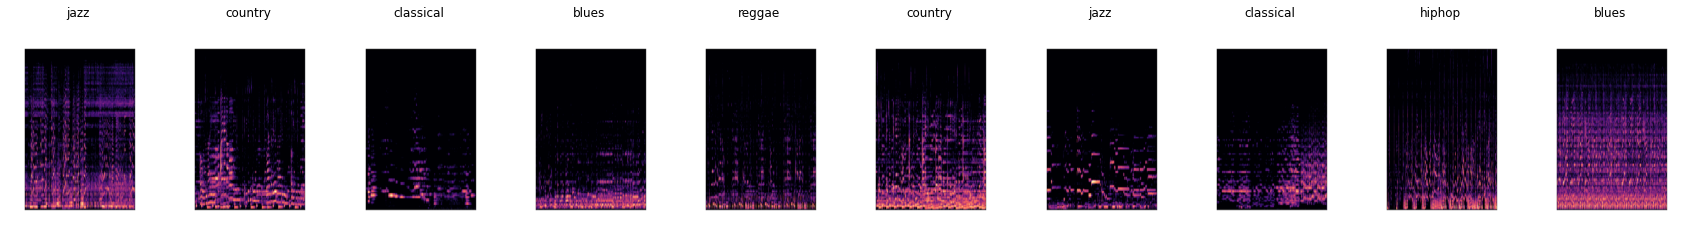

In [25]:
# https://www.tensorflow.org/tutorials/load_data/images

plt.figure(figsize=(30, 50))

for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# CNN

In [26]:
#https://www.tensorflow.org/tutorials/images/classification
batch_size, img_height, img_width, channels = (32, 432, 288, 3)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.25, seed=42))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.25, seed=42))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.25, seed=42))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
model.add(layers.Dropout(0.25, seed=42))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)))
model.add(layers.Dropout(0.25, seed=42))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.02)))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 432, 288, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 432, 288, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 144, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 144, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 72, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 72, 64)       1

In [27]:
early_stopper = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
hist = model.fit(tr_ds, validation_data=val_ds, epochs=150, callbacks=[early_stopper])

Epoch 1/150
23/23 [==============================] - 101s 4s/step - loss: 15.0118 - accuracy: 0.0847 - val_loss: 13.7102 - val_accuracy: 0.1000
Epoch 2/150
23/23 [==============================] - 99s 4s/step - loss: 12.6813 - accuracy: 0.1111 - val_loss: 11.5930 - val_accuracy: 0.0875
Epoch 3/150
23/23 [==============================] - 100s 4s/step - loss: 10.7672 - accuracy: 0.1069 - val_loss: 9.9104 - val_accuracy: 0.0875
Epoch 4/150
23/23 [==============================] - 99s 4s/step - loss: 9.2660 - accuracy: 0.1125 - val_loss: 8.6071 - val_accuracy: 0.0875
Epoch 5/150
23/23 [==============================] - 104s 5s/step - loss: 8.1151 - accuracy: 0.1319 - val_loss: 7.6083 - val_accuracy: 0.1250
Epoch 6/150
23/23 [==============================] - 103s 5s/step - loss: 7.2225 - accuracy: 0.1556 - val_loss: 6.8360 - val_accuracy: 0.1250
Epoch 7/150
23/23 [==============================] - 98s 4s/step - loss: 6.5087 - accuracy: 0.1681 - val_loss: 6.2155 - val_accuracy: 0.1875
Epoc

In [29]:
score = model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 2.056602716445923 and val_acc = 0.6150000095367432


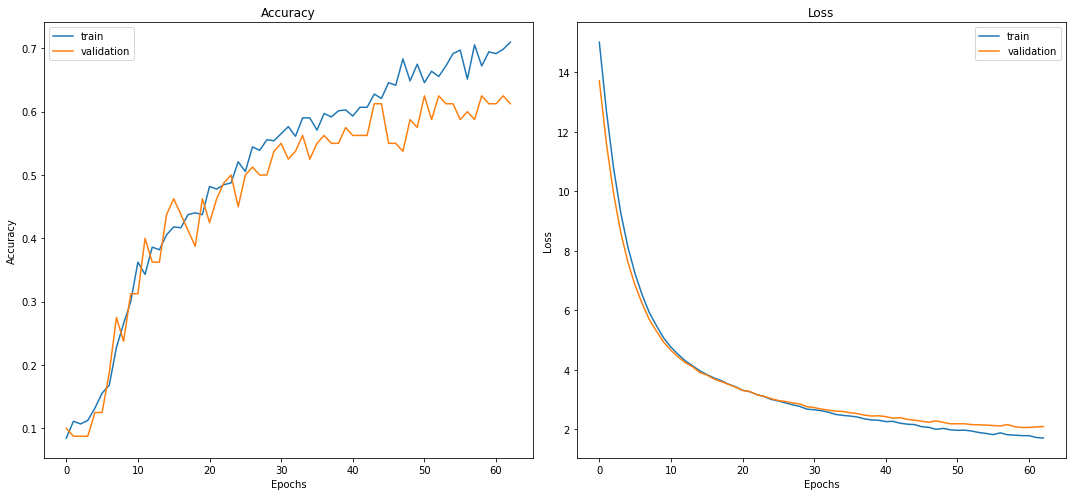

In [30]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
model.save('/content/drive/MyDrive/Springboard/SavedModel/custom_cnn.h5')

# An Exploration of Transfer Learning:
Mobile Net & VGG Net

In [32]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications